# Time Series Prediction with LSTM

#### Import necessary library needed for the model training

#Steps
1. Get the stock data
2. Add Technical Indicators
3. Get VIX data
4. Combine to create a feature vector
5. Convert to series
6. Set up the LSTM Model
7. Build the model
8. Make Predictions
9. Experiments to tune hyper parameters

In [1]:
!pip install TA-lib
!pip install quandl
import talib as ta
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


#### Use Quandl api 

In [2]:
import quandl
quandl.ApiConfig.api_key = "8zKAkyPxYjMss6sbu_E2"

#data = quandl.get('WIKI/GOOG',start_date=startdate,end_date=enddate, returns='pandas')

Get the stock data and only keep the columns that will be used

In [3]:
def getStockData(sym, startdate, enddate):
    mydata = quandl.get('WIKI/'+sym,start_date=startdate,end_date=enddate, returns='pandas')
    mydata = mydata.drop(['Open','High','Low','Close','Volume','Ex-Dividend','Split Ratio'], axis=1)
    return mydata

Get the VIX volatility data and remove the columns that are not needed

In [4]:
def getVIXData(startdate, enddate):
    vixdata = quandl.get('CHRIS/CBOE_VX1',start_date=startdate,end_date=enddate, returns='pandas')
    vixdata = vixdata.drop(['Open','High','Low','Settle','Change','Total Volume','EFP', 'Prev. Day Open Interest'], axis=1)
    vixdata.rename(columns={"Close": "VIX"}, inplace=True)
    return vixdata

Calculate select technical indicators and add as features

In [5]:
def calcIndicators(mydata, priceName, volName):
    # adding 9 additional features 
    
    #mydata['BB_up'], mydata['BB_mid'],mydata['BB_low'] = ta.BBANDS(np.asarray(mydata['Close']), 20)

    # Lagging Indictors (Trend)
    mydata['EMA_50'] = ta.EMA(np.asarray(mydata[priceName]), 50)
    mydata['EMA_100'] = ta.EMA(np.asarray(mydata[priceName]), 100)
    mydata['EMA_200'] = ta.EMA(np.asarray(mydata[priceName]), 200)
    #mydata['SMA_200'] = ta.EMA(np.asarray(mydata[priceName]), 200)

    # Oscillators (Momentum)
    mydata['RSI'] = ta.RSI(np.asarray(mydata[priceName]),14)
    #mydata['STO_k'], mydata['STO_d'] = ta.STOCHF(np.asarray(mydata['High']), np.asarray(mydata['Low']), \
    #                                 np.asarray(mydata['Close']), fastk_period=5, fastd_period=3, fastd_matype=0)
    mydata['Macd'], mydata['Macdsignal'], mydata['Macdhist'] = ta.MACD(np.asarray(mydata[priceName]),  \
                                                        fastperiod=12, slowperiod=26, signalperiod=9)

    # Volume Indicators
    mydata['MFI'] = ta.RSI(np.asarray(mydata[priceName]),14)
    mydata['OBV'] = ta.OBV(np.asarray(mydata[priceName]),np.asarray(mydata[volName]))
    #mydata['OBV_50'] = ta.EMA(np.asarray(mydata['OBV']), 50)
    #mydata['OBV_100'] = ta.EMA(np.asarray(mydata['OBV']), 100)
    #mydata['OBV_200'] = ta.EMA(np.asarray(mydata['OBV']), 200)

Merge (outer join) the stock feature dataframe with VIX dataframe using the time index, drop all the NaN rows

In [6]:
def mergeColumns(stockdata,vixdata):
    newdata = pd.concat([stockdata,vixdata],axis =1)
    newdata.dropna(inplace=True)
    return newdata

In [7]:
def addTarget(data,targetName,days):
    #a.x2 = a.x2.shift(1)
    data['Target']= data[targetName].shift(days)
    data.dropna(inplace=True)
    data = data.astype('float32')
    #print(data)
    #print('--------')
    
    # need to return a numpy array rather than pandas dataframe
    return data.values

Normalize the feature vector for use by the classifier

In [8]:
def normalizeData(data):
    # Rescale all the vales in the table
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    return scaler, scaled

Split data into training and Test

In [9]:
def trainingTestSplit(scaled, trainRatio):
    n_train_hours = int(len(scaled) * trainRatio)
    train = scaled[:n_train_hours, :]
    test = scaled[n_train_hours:, :]
    
    # split into input and outputs
    train_X, train_Y = train[:, :-1], train[:, -1]
    test_X, test_Y = test[:, :-1], test[:, -1]
    print('train X,Y, testX,Y:',train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
    
    #reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    #print(type(test_X))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print('After reshape:', train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
    
    return train_X, train_Y, test_X, test_Y

vixdata = vixdata.drop(['Open','High','Low','Settle','Change','Total Volume','EFP', 'Prev. Day Open Interest'], axis=1)
vixdata.rename(columns={"Close": "VIX"}, inplace=True)
data = dropColumns(data)
vixdata.tail()
newdata = pd.concat([data,vixdata],axis =1)
newdata.tail()
newdata.dropna(inplace=True)
print(newdata.shape)

values = series_to_features(newdata)
values = values.astype('float32')
print(type(values))
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)

#values = reframed.values
#n_train_hours = int(len(values) * 0.7)
n_train_hours = int(len(scaled) * 0.7)
train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
print(type(test_X))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [10]:
def trainModel(train_X,train_Y,test_X,test_Y,epoch,numNeuron):
    multi_model = Sequential()
    multi_model.add(LSTM(numNeuron, input_shape=(train_X.shape[1], train_X.shape[2])))
    multi_model.add(Dense(1))
    multi_model.compile(loss='mae', optimizer='adam')
    multi_history = multi_model.fit(train_X, train_Y, epochs=300, batch_size=100, validation_data=(test_X, test_Y), verbose=0, shuffle=False)
    
    # plot results
    pyplot.plot(multi_history.history['loss'], label='multi_train')
    pyplot.plot(multi_history.history['val_loss'], label='multi_test')
    pyplot.legend()
    pyplot.show()
    
    return multi_model

Test model predictions against the test data

In [11]:
def testModel(multi_model, test_X,test_Y):
    #print(test_X[:5])
    yhat = multi_model.predict(test_X)
    print(yhat.shape)
    pyplot.plot(yhat, label='predict')
    pyplot.plot(test_Y, label='true')
    pyplot.legend()
    pyplot.show()
    
    return yhat

#### Scaler Inverse Y back to normal value

In [12]:
def calcPredError(test_X, test_Y, yhat, scaler):
    #print(test_X.shape)
    #print(test_X)
    #print(yhat.shape)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    #print(test_X.shape)
    # invert scaling for forecast
    #print(yhat.shape)
    #test_X = np.append(test_X, yhat, 1)
    test_X = np.concatenate((test_X,yhat),axis=1)
    #print(test_X.shape)
    #inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    #print(inv_yhat.shape)
    inv_yhat = scaler.inverse_transform(test_X)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_Y = test_Y.reshape((len(test_Y), 1))
    inv_y = concatenate((test_Y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    return rmse

Main Function

2018-10-20
2015-07-08
Feature Vectors shape prior train/test split: (482, 15)
train X,Y, testX,Y: (339, 14) (339,) (146, 14) (146,)
After reshape: (339, 1, 14) (339,) (146, 1, 14) (146,)


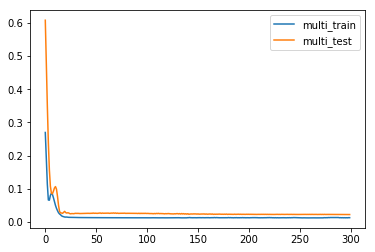

(146, 1)


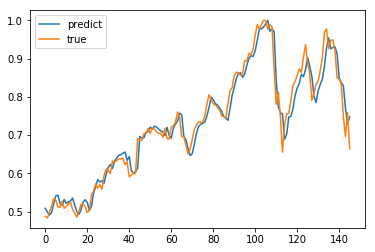

Test RMSE: 20.590
train X,Y, testX,Y: (338, 14) (338,) (145, 14) (145,)
After reshape: (338, 1, 14) (338,) (145, 1, 14) (145,)


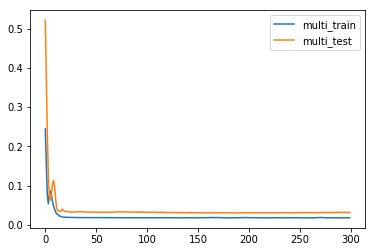

(145, 1)


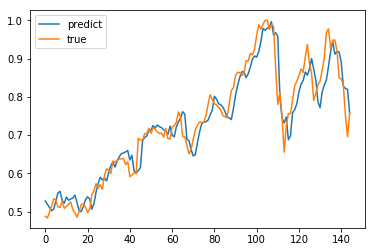

Test RMSE: 25.758
train X,Y, testX,Y: (336, 14) (336,) (144, 14) (144,)
After reshape: (336, 1, 14) (336,) (144, 1, 14) (144,)


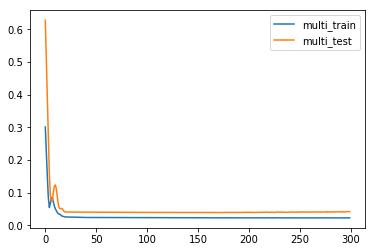

(144, 1)


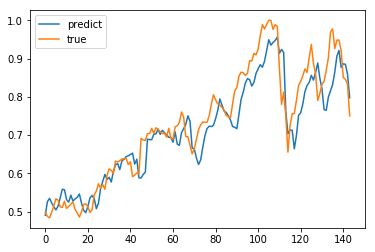

Test RMSE: 30.919
train X,Y, testX,Y: (333, 14) (333,) (143, 14) (143,)
After reshape: (333, 1, 14) (333,) (143, 1, 14) (143,)


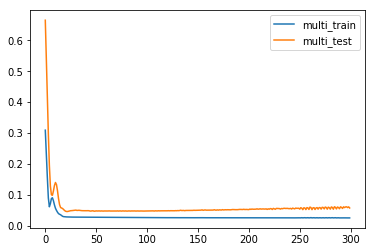

(143, 1)


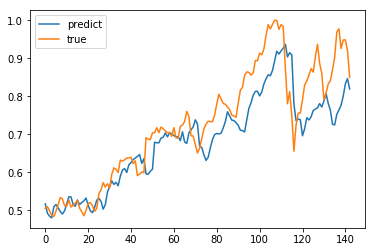

Test RMSE: 34.678
train X,Y, testX,Y: (329, 14) (329,) (142, 14) (142,)
After reshape: (329, 1, 14) (329,) (142, 1, 14) (142,)


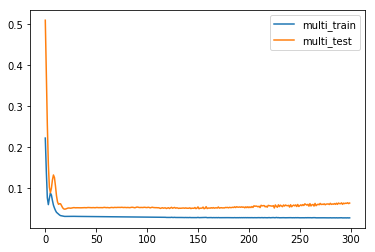

(142, 1)


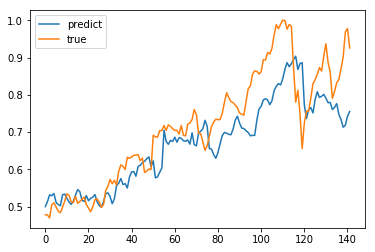

Test RMSE: 37.758
train X,Y, testX,Y: (325, 14) (325,) (140, 14) (140,)
After reshape: (325, 1, 14) (325,) (140, 1, 14) (140,)


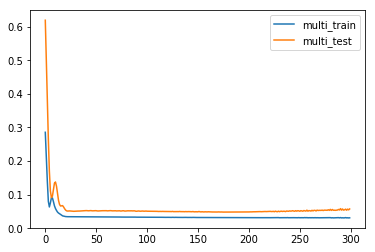

(140, 1)


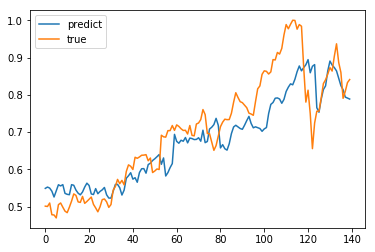

Test RMSE: 39.147
train X,Y, testX,Y: (320, 14) (320,) (138, 14) (138,)
After reshape: (320, 1, 14) (320,) (138, 1, 14) (138,)


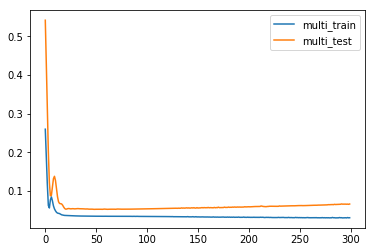

(138, 1)


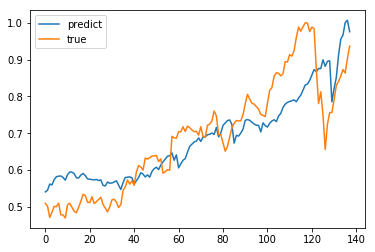

Test RMSE: 42.214
train X,Y, testX,Y: (315, 14) (315,) (135, 14) (135,)
After reshape: (315, 1, 14) (315,) (135, 1, 14) (135,)


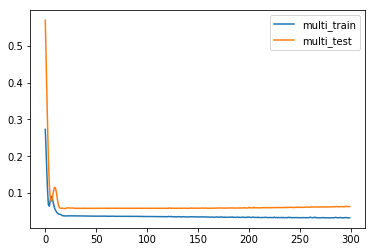

(135, 1)


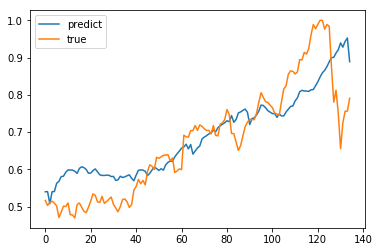

Test RMSE: 42.340
train X,Y, testX,Y: (308, 14) (308,) (133, 14) (133,)
After reshape: (308, 1, 14) (308,) (133, 1, 14) (133,)


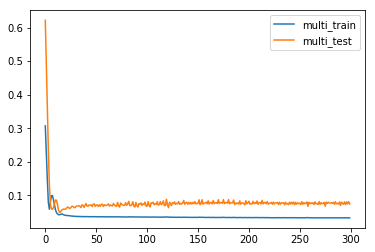

(133, 1)


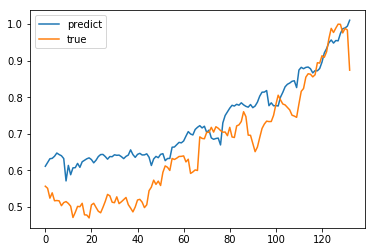

Test RMSE: 27.136
train X,Y, testX,Y: (301, 14) (301,) (130, 14) (130,)
After reshape: (301, 1, 14) (301,) (130, 1, 14) (130,)


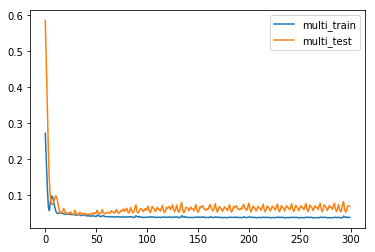

(130, 1)


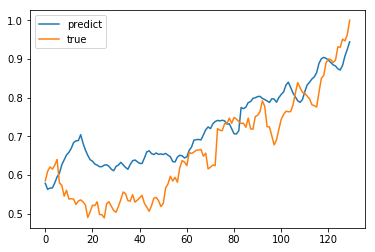

Test RMSE: 35.087
train X,Y, testX,Y: (294, 14) (294,) (126, 14) (126,)
After reshape: (294, 1, 14) (294,) (126, 1, 14) (126,)


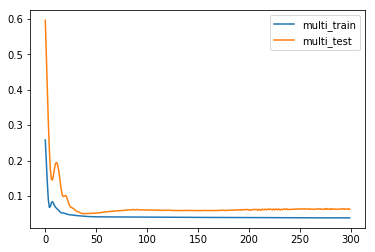

(126, 1)


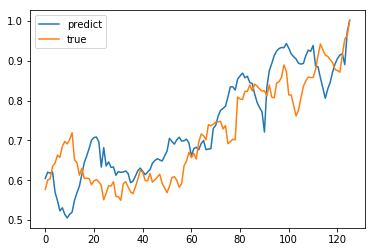

Test RMSE: 27.268
train X,Y, testX,Y: (285, 14) (285,) (123, 14) (123,)
After reshape: (285, 1, 14) (285,) (123, 1, 14) (123,)


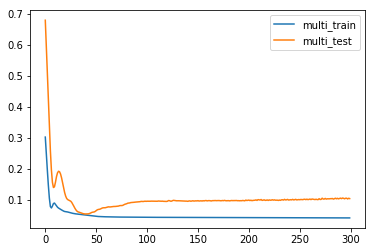

(123, 1)


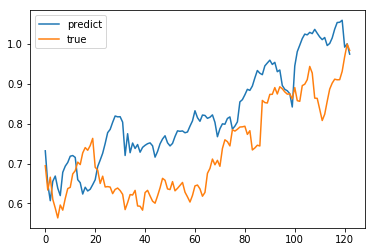

Test RMSE: 29.413
train X,Y, testX,Y: (276, 14) (276,) (119, 14) (119,)
After reshape: (276, 1, 14) (276,) (119, 1, 14) (119,)


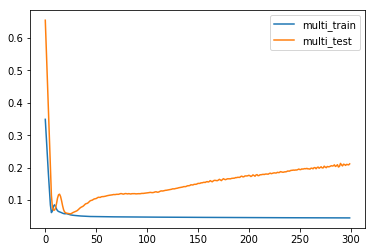

(119, 1)


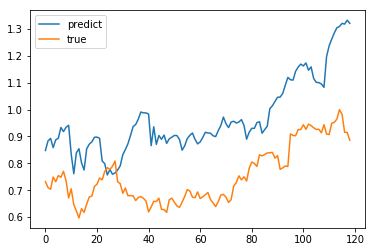

Test RMSE: 30.634
    Days Ahead      RMSE:
0            1  20.590007
1            2  25.757604
2            3  30.918656
3            4  34.677661
4            5  37.758151
5            6  39.146502
6            7  42.214251
7            8  42.339574
8            9  27.135791
9           10  35.087207
10          11  27.268013
11          12  29.413163
12          13  30.634058


In [13]:
from datetime import date, timedelta
enddate = date.today().strftime('%Y-%m-%d')
print(enddate)
startdate = (date.today() - timedelta(1200)).strftime('%Y-%m-%d')
print(startdate)

sym = 'GOOG'
trainRatio = 0.7
epoch = 100
numNeuron = 100
daysShift = -1 # -1 Predict on day ahead, -2 2 days ahead...

mydata =  getStockData(sym, startdate, enddate)
vixdata = getVIXData(startdate, enddate)
calcIndicators(mydata, 'Adj. Close', 'Adj. Volume')
newdata = mergeColumns(mydata,vixdata)
print('Feature Vectors shape prior train/test split:',newdata.shape)
newdata.tail()

days = []
rmse = []

for i in range(1,14):
    daysShift = i*-1
    days.append(i)
    features = addTarget(mydata,'Adj. Close',daysShift)
    scaler, scaled = normalizeData(features)

    train_X, train_Y, test_X, test_Y = trainingTestSplit(scaled, trainRatio)

    multi_model = trainModel(train_X,train_Y,test_X,test_Y,epoch,numNeuron)

    yhat = testModel(multi_model, test_X,test_Y)
    
    rmse.append(calcPredError(test_X,test_Y, yhat, scaler))
    
    
results = pd.DataFrame({'Days Ahead':days,'RMSE:':rmse})
print(results)


#### Plot line graph 

predictDates = data.tail(len(test_X)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Var Predict Price')
#predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
#py.iplot([predict_chart, multi_predict_chart, actual_chart])
py.iplot([multi_predict_chart, actual_chart])